In [2]:
import os
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
import joblib

313/313 ━━━━━━━━━━━━━━━━━━━━ 238s 747ms/step


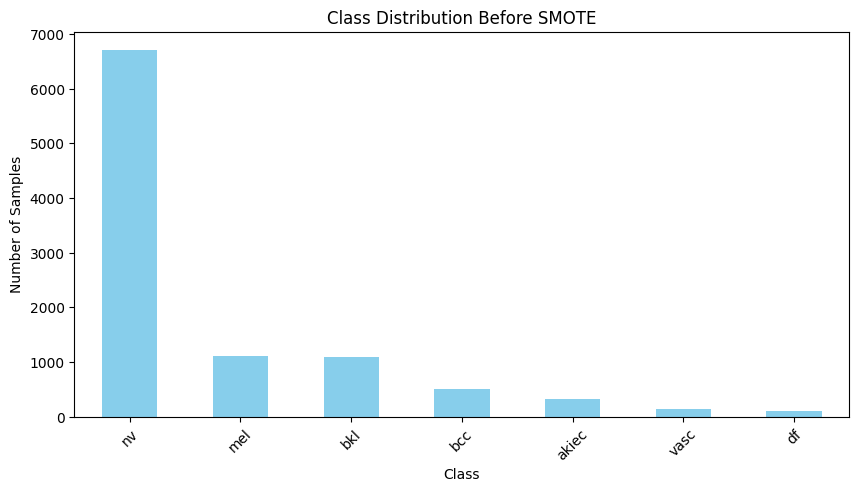

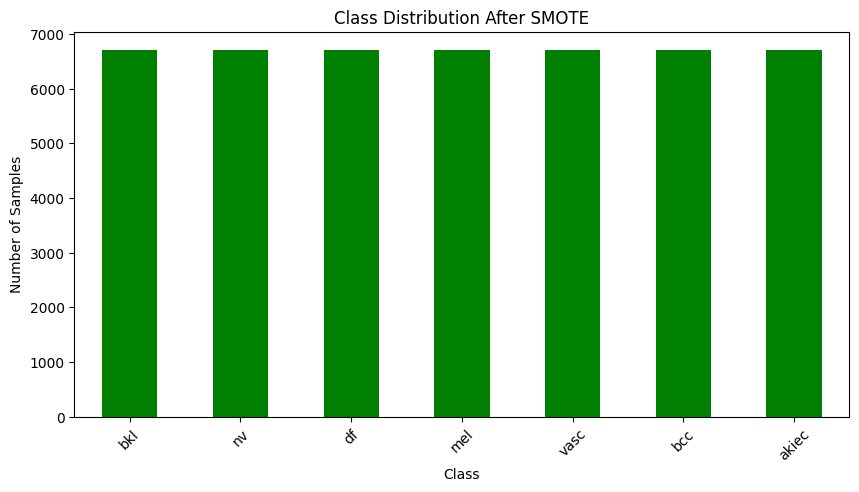

SMOTEd dataset saved to 'HAM10000_resampled_dataset.csv'


In [8]:
import os
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
import matplotlib.pyplot as plt

# --- Step 1: Load Metadata ---
metadata = pd.read_csv('HAM10000_metadata.csv')

# --- Step 2: Load and Preprocess Images ---
def load_images(directory):
    images = {}
    for filename in os.listdir(directory):
        if filename.endswith('.jpg'):
            image_id = filename.split('.')[0]
            img_path = os.path.join(directory, filename)
            img = Image.open(img_path).resize((128, 128))
            images[image_id] = img
    return images

images_dir_1 = 'HAM10000_images_part_1'
images_dir_2 = 'HAM10000_images_part_2'

images_1 = load_images(images_dir_1)
images_2 = load_images(images_dir_2)

all_images = {**images_1, **images_2}

# Filter metadata to include only available images
metadata = metadata[metadata['image_id'].isin(all_images.keys())]

# Extract labels and image arrays
labels = metadata['dx']
image_arrays = np.array([np.array(all_images[img_id]) for img_id in metadata['image_id']])

# Encode labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Preprocess image arrays
image_arrays = preprocess_input(image_arrays)

# --- Step 3: Feature Extraction Using EfficientNetB0 ---
model = EfficientNetB0(include_top=False, weights='imagenet', pooling='avg', input_shape=(128, 128, 3))
features = model.predict(image_arrays)

# --- Step 4: Visualize Class Distribution Before SMOTE ---
original_counts = pd.DataFrame(labels, columns=['dx'])['dx'].value_counts()
plt.figure(figsize=(10, 5))
original_counts.plot(kind='bar', color='skyblue')
plt.title("Class Distribution Before SMOTE")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.xticks(rotation=45)
plt.show()

# --- Step 5: Apply SMOTE ---
smote = SMOTE(sampling_strategy='auto', random_state=42)
features_resampled, labels_resampled = smote.fit_resample(features, labels_encoded)

# Decode resampled labels back to original class names
labels_resampled_decoded = label_encoder.inverse_transform(labels_resampled)

# --- Step 6: Visualize Class Distribution After SMOTE ---
resampled_counts = pd.DataFrame(labels_resampled_decoded, columns=['dx'])['dx'].value_counts()
plt.figure(figsize=(10, 5))
resampled_counts.plot(kind='bar', color='green')
plt.title("Class Distribution After SMOTE")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.xticks(rotation=45)
plt.show()

# --- Step 7: Save Resampled Dataset to CSV ---
# Combine features and labels into a DataFrame
features_df = pd.DataFrame(features_resampled, columns=[f'feature_{i}' for i in range(features_resampled.shape[1])])
labels_df = pd.DataFrame(labels_resampled_decoded, columns=['dx'])

# Merge features and labels
resampled_dataset = pd.concat([features_df, labels_df], axis=1)

# Save to CSV
resampled_dataset.to_csv('HAM10000_resampled_dataset.csv', index=False)

print("SMOTEd dataset saved to 'HAM10000_resampled_dataset.csv'")


c:\Python312\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Final Generator Loss: 0.6546587944030762, Final Discriminator Loss: 1.3810455799102783


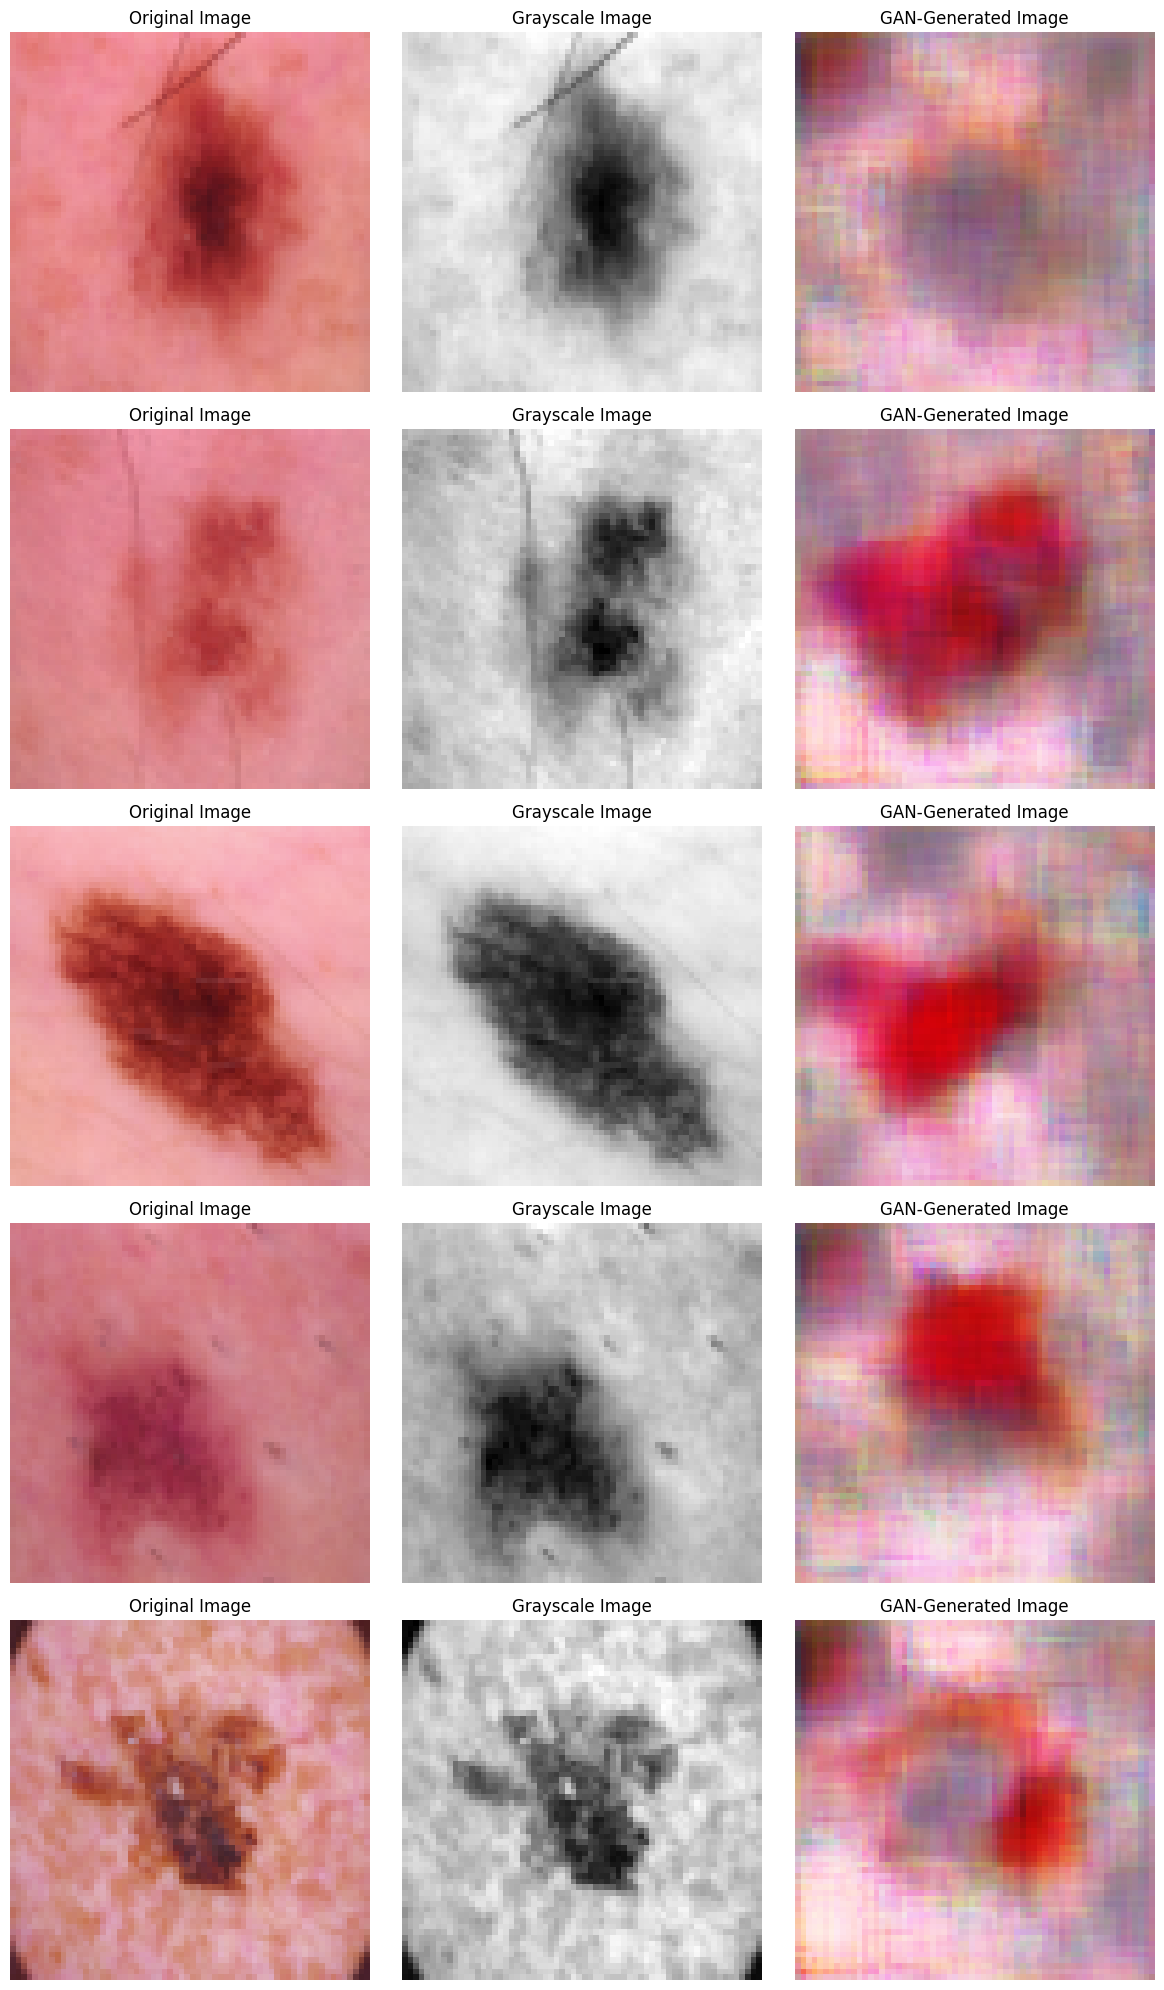

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image

# Define the AdvancedSkinLesionGAN class
class AdvancedSkinLesionGAN:
    def __init__(self, img_shape=(64, 64, 3), latent_dim=100):
        self.img_shape = img_shape
        self.latent_dim = latent_dim

        # Learning rates with exponential decay
        self.d_learning_rate = keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=1e-4, decay_steps=10000, decay_rate=0.9
        )
        self.g_learning_rate = keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=1e-4, decay_steps=10000, decay_rate=0.9
        )

        self.generator = self._build_generator()
        self.discriminator = self._build_discriminator()

        self.cross_entropy = tf.keras.losses.BinaryCrossentropy()

        self.gen_optimizer = keras.optimizers.Adam(learning_rate=self.g_learning_rate)
        self.disc_optimizer = keras.optimizers.Adam(learning_rate=self.d_learning_rate)

    def _build_generator(self):
        def residual_block(x, filters):
            shortcut = x
            shortcut = layers.Conv2DTranspose(filters, kernel_size=1, padding='same')(shortcut)
            x = layers.Conv2DTranspose(filters, kernel_size=3, padding='same')(x)
            x = layers.BatchNormalization()(x)
            x = layers.Add()([shortcut, x])
            x = layers.LeakyReLU(alpha=0.2)(x)
            return x

        noise = layers.Input(shape=(self.latent_dim,))
        x = layers.Dense(8 * 8 * 512)(noise)
        x = layers.Reshape((8, 8, 512))(x)

        x = layers.UpSampling2D()(x)
        x = residual_block(x, 256)
        x = layers.UpSampling2D()(x)
        x = residual_block(x, 128)
        x = layers.UpSampling2D()(x)
        x = residual_block(x, 64)

        img = layers.Conv2DTranspose(self.img_shape[-1], kernel_size=3, padding='same', activation='tanh')(x)

        return keras.Model(noise, img, name="Generator")

    def _build_discriminator(self):
        img = layers.Input(shape=self.img_shape)

        x = layers.Conv2D(64, kernel_size=3, strides=2, padding='same')(img)
        x = layers.LeakyReLU(alpha=0.2)(x)
        x = layers.Dropout(0.3)(x)

        x = layers.Conv2D(128, kernel_size=3, strides=2, padding='same')(x)
        x = layers.LeakyReLU(alpha=0.2)(x)
        x = layers.Dropout(0.3)(x)

        x = layers.Conv2D(256, kernel_size=3, strides=2, padding='same')(x)
        x = layers.LeakyReLU(alpha=0.2)(x)
        x = layers.Dropout(0.3)(x)

        x = layers.Flatten()(x)
        validity = layers.Dense(1, activation='sigmoid')(x)

        return keras.Model(img, validity, name="Discriminator")

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]

        # Generate random noise
        noise = tf.random.normal([batch_size, self.latent_dim])

        # Train Discriminator
        with tf.GradientTape() as disc_tape:
            fake_images = self.generator(noise, training=True)

            real_output = self.discriminator(real_images, training=True)
            fake_output = self.discriminator(fake_images, training=True)

            real_loss = self.cross_entropy(tf.ones_like(real_output), real_output)
            fake_loss = self.cross_entropy(tf.zeros_like(fake_output), fake_output)
            disc_loss = real_loss + fake_loss

        gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)
        self.disc_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))

        # Train Generator
        with tf.GradientTape() as gen_tape:
            fake_images = self.generator(noise, training=True)
            fake_output = self.discriminator(fake_images, training=True)
            gen_loss = self.cross_entropy(tf.ones_like(fake_output), fake_output)

        gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        self.gen_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))

        return gen_loss, disc_loss

    def train(self, dataset, epochs=50):
        for epoch in range(epochs):
            for real_images in dataset:
                gen_loss, disc_loss = self.train_step(real_images)
        return gen_loss, disc_loss

# Helper function to load and preprocess images from a directory
def load_images_from_directory(directory, img_shape=(64, 64)):
    images = []
    for file_name in os.listdir(directory):
        file_path = os.path.join(directory, file_name)
        try:
            img = Image.open(file_path).convert('RGB')
            img = img.resize(img_shape[:2])
            images.append(np.array(img))
        except Exception as e:
            print(f"Error loading image {file_path}: {e}")
    images = np.array(images) / 127.5 - 1.0  # Normalize to [-1, 1]
    return tf.data.Dataset.from_tensor_slices(images).batch(32), images

# Display original, grayscale, and GAN-generated images
def display_images(original_images, gan, latent_dim=100):
    noise = tf.random.normal([len(original_images), latent_dim])
    generated_images = gan.generator(noise, training=False).numpy()

    fig, axes = plt.subplots(len(original_images), 3, figsize=(12, len(original_images) * 4))
    for i, img in enumerate(original_images):
        gray_img = np.dot(img[..., :3], [0.2989, 0.5870, 0.1140])
        gan_img = (generated_images[i] + 1) / 2  # Rescale to [0, 1]

        axes[i, 0].imshow((img + 1) / 2)
        axes[i, 0].set_title("Original Image")
        axes[i, 0].axis('off')

        axes[i, 1].imshow(gray_img, cmap='gray')
        axes[i, 1].set_title("Grayscale Image")
        axes[i, 1].axis('off')

        axes[i, 2].imshow(gan_img)
        axes[i, 2].set_title("GAN-Generated Image")
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

# Main function
def main():
    IMAGE_DIR = r"C:\Users\rdeva\Downloads\SEM3\SEM4\Deep_Learning\HAM10000_images_part_1"  # Update with your directory path

    # Load and preprocess data
    dataset, original_images = load_images_from_directory(IMAGE_DIR)

    # Initialize and train GAN
    gan = AdvancedSkinLesionGAN(img_shape=(64, 64, 3))
    gen_loss, disc_loss = gan.train(dataset, epochs=4)  # Train for 5 epochs

    print(f"Final Generator Loss: {gen_loss}, Final Discriminator Loss: {disc_loss}")

    # Display images
    display_images(original_images[:5], gan)  # Display first 5 images

if __name__ == "__main__":
    main()

Loading and preprocessing images...
Found 5000 images in directory
Processed 100 images...
Processed 200 images...
Processed 300 images...
Processed 400 images...
Processed 500 images...
Processed 600 images...
Processed 700 images...
Processed 800 images...
Processed 900 images...
Processed 1000 images...
Processed 1100 images...
Processed 1200 images...
Processed 1300 images...
Processed 1400 images...
Processed 1500 images...
Processed 1600 images...
Processed 1700 images...
Processed 1800 images...
Processed 1900 images...
Processed 2000 images...
Processed 2100 images...
Processed 2200 images...
Processed 2300 images...
Processed 2400 images...
Processed 2500 images...
Processed 2600 images...
Processed 2700 images...
Processed 2800 images...
Processed 2900 images...
Processed 3000 images...
Processed 3100 images...
Processed 3200 images...
Processed 3300 images...
Processed 3400 images...
Processed 3500 images...
Processed 3600 images...
Processed 3700 images...
Processed 3800 im

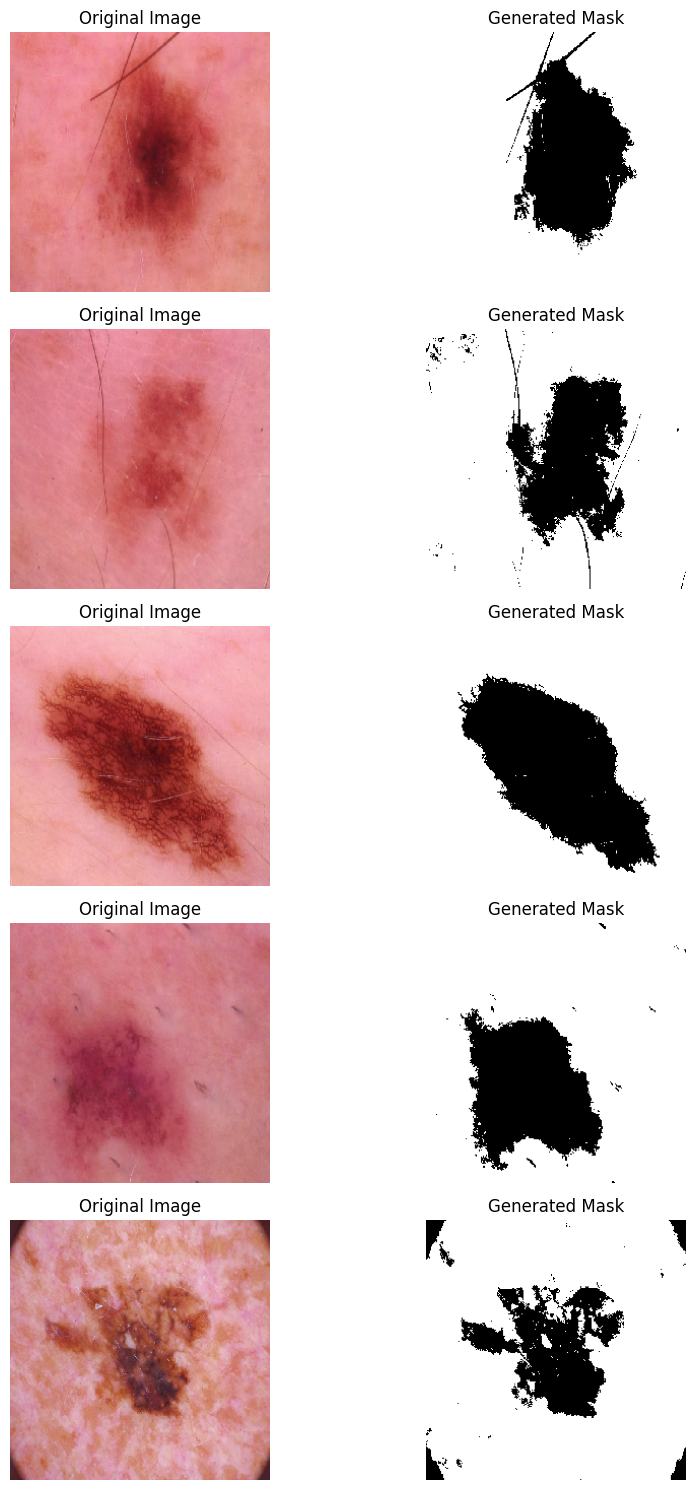


Training model...

Training with:
Training samples: 4000
Validation samples: 1000
Epoch 1/10
209/250 ━━━━━━━━━━━━━━━━━━━━ 5:33 8s/step - accuracy: 0.8344 - loss: 0.3903

KeyboardInterrupt: 

In [8]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, Concatenate
from skimage.filters import threshold_otsu
from skimage.color import rgb2gray

def load_images_from_directory(image_dir, target_size=(256, 256), verbose=True):
    """
    Load images from a directory and create corresponding masks using Otsu thresholding.
    This approach assumes the lesions are distinguishable from the background.
    
    Parameters:
    image_dir: Directory containing the images
    target_size: Size to resize images to
    verbose: Whether to print progress information
    
    Returns:
    tuple: (preprocessed_images, original_images)
    """
    # Verify directory exists
    if not os.path.exists(image_dir):
        raise FileNotFoundError(f"Image directory not found: {image_dir}")
    
    # Get list of image files
    image_files = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
    
    if verbose:
        print(f"Found {len(image_files)} images in directory")
    
    preprocessed_images = []
    original_images = []
    skipped_images = []
    
    for idx, img_file in enumerate(image_files):
        try:
            # Load and preprocess image
            img_path = os.path.join(image_dir, img_file)
            
            # Load original image
            img = load_img(img_path, target_size=target_size)
            img_array = img_to_array(img)
            
            # Store original image (normalized)
            original_images.append(img_array / 255.0)
            
            # Convert to grayscale for thresholding
            gray_img = rgb2gray(img_array)
            
            # Apply Otsu thresholding to create mask
            threshold = threshold_otsu(gray_img)
            binary_mask = (gray_img > threshold).astype(np.float32)
            
            # Reshape mask to match expected dimensions (height, width, 1)
            binary_mask = np.expand_dims(binary_mask, axis=-1)
            
            preprocessed_images.append(binary_mask)
            
            # Print progress
            if verbose and (idx + 1) % 100 == 0:
                print(f"Processed {idx + 1} images...")
                
        except Exception as e:
            skipped_images.append((img_file, str(e)))
    
    # Convert lists to numpy arrays
    preprocessed_images = np.array(preprocessed_images)
    original_images = np.array(original_images)
    
    if verbose:
        print("\nData Loading Summary:")
        print(f"Successfully loaded: {len(preprocessed_images)} images")
        print(f"Skipped: {len(skipped_images)} images")
        if len(preprocessed_images) > 0:
            print(f"Image shape: {original_images.shape}")
            print(f"Mask shape: {preprocessed_images.shape}")
        if skipped_images:
            print("\nFirst few skipped images and reasons:")
            for img_file, reason in skipped_images[:5]:
                print(f"- {img_file}: {reason}")
    
    if len(preprocessed_images) == 0:
        raise ValueError(
            "No images were successfully loaded. Please check:\n"
            "1. Image directory path\n"
            "2. Image file formats (.jpg, .jpeg, .png)\n"
            "3. File permissions"
        )
    
    return preprocessed_images, original_images

def train_model(X, y, epochs=50, batch_size=16, validation_split=0.2):
    """
    Train the UNet++ model with the loaded images and generated masks
    """
    if len(X) < 2:
        raise ValueError("Need at least 2 samples to split into train and validation sets")
    
    # Split data
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, 
        test_size=validation_split,
        random_state=42
    )
    
    print(f"\nTraining with:")
    print(f"Training samples: {len(X_train)}")
    print(f"Validation samples: {len(X_val)}")
    
    # Create and compile model
    model = unet_plus_plus()
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    # Train model
    history = model.fit(
        X_train,
        y_train,
        validation_data=(X_val, y_val),
        batch_size=batch_size,
        epochs=epochs,
        verbose=1
    )
    
    return model, history

def display_sample_results(original_images, masks, num_samples=5):
    """
    Display sample images and their generated masks
    """
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, num_samples * 3))
    
    for idx in range(min(num_samples, len(original_images))):
        # Display original image
        axes[idx, 0].imshow(original_images[idx])
        axes[idx, 0].set_title('Original Image')
        axes[idx, 0].axis('off')
        
        # Display mask
        axes[idx, 1].imshow(masks[idx].squeeze(), cmap='gray')
        axes[idx, 1].set_title('Generated Mask')
        axes[idx, 1].axis('off')
    
    plt.tight_layout()
    plt.show()

# Main execution
if __name__ == "__main__":
    IMAGE_DIR = r"C:\Users\rdeva\Downloads\SEM3\SEM4\Deep_Learning\HAM10000_images_part_1"
    
    try:
        # Load and preprocess data
        print("Loading and preprocessing images...")
        masks, images = load_images_from_directory(IMAGE_DIR)
        
        # Display some sample results before training
        print("\nDisplaying sample preprocessed images and masks...")
        display_sample_results(images, masks)
        
        # Train the model
        print("\nTraining model...")
        model, history = train_model(images, masks, epochs=10)
        
        # Make predictions and display results
        print("\nGenerating predictions...")
        predictions = model.predict(images[:5])
        
        # Display final results
        plt.figure(figsize=(15, 5))
        for i in range(5):
            plt.subplot(1, 3, 1)
            plt.imshow(images[i])
            plt.title("Original Image")
            
            plt.subplot(1, 3, 2)
            plt.imshow(masks[i].squeeze(), cmap='gray')
            plt.title("Generated Mask")
            
            plt.subplot(1, 3, 3)
            plt.imshow(predictions[i].squeeze(), cmap='gray')
            plt.title("Model Prediction")
            
            plt.show()
            
    except Exception as e:
        print(f"\nError occurred: {str(e)}")
        print("\nTroubleshooting steps:")
        print("1. Verify the image directory path")
        print("2. Check if the directory contains supported image files (.jpg, .jpeg, .png)")
        print("3. Ensure you have read permissions for the directory")
        print("4. Make sure you have enough memory to process the images")

In [11]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


Loading and preprocessing data...
Creating and compiling UNet++ model...
Training model...
Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.5045 - loss: 0.6931 - val_accuracy: 0.6917 - val_loss: 0.6295
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7047 - loss: 0.6370 - val_accuracy: 0.6917 - val_loss: 0.5826
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7047 - loss: 0.5955 - val_accuracy: 0.6917 - val_loss: 0.7415
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7047 - loss: 0.7431 - val_accuracy: 0.6917 - val_loss: 0.5773
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7047 - loss: 0.5922 - val_accuracy: 0.6917 - val_loss: 0.5816
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7047 - loss: 0.5964 - val_accuracy: 0.6917 - val_loss: 0.5902
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7047 - loss: 0.6046 - val_accuracy: 0.6917 - val_loss: 0.5903
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step -

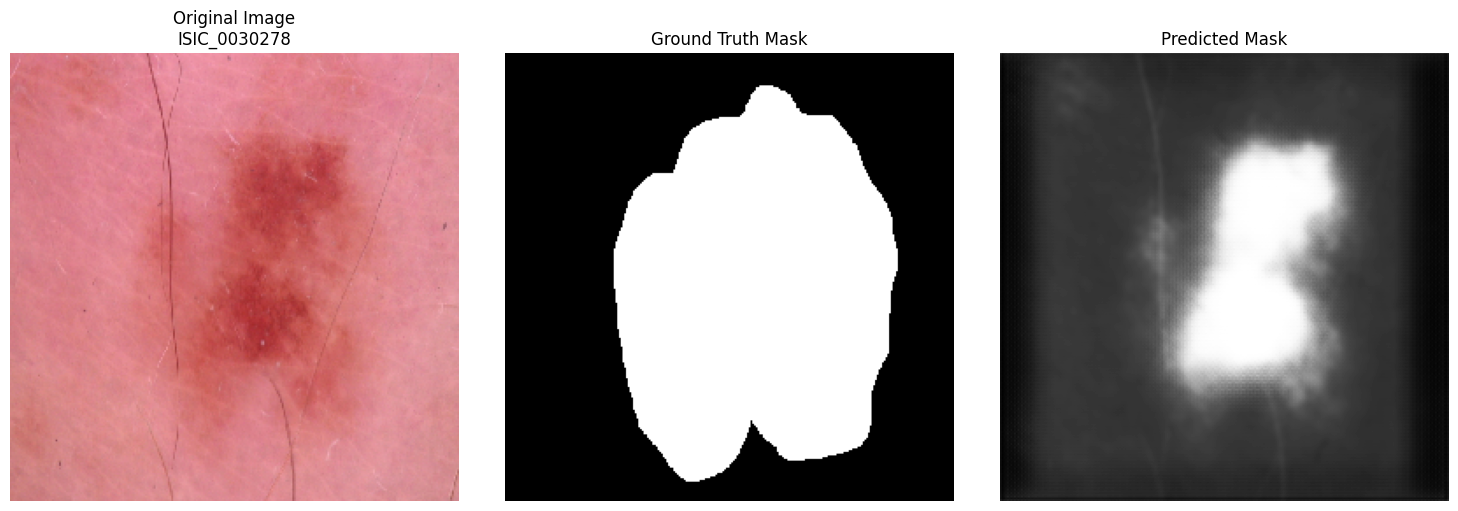

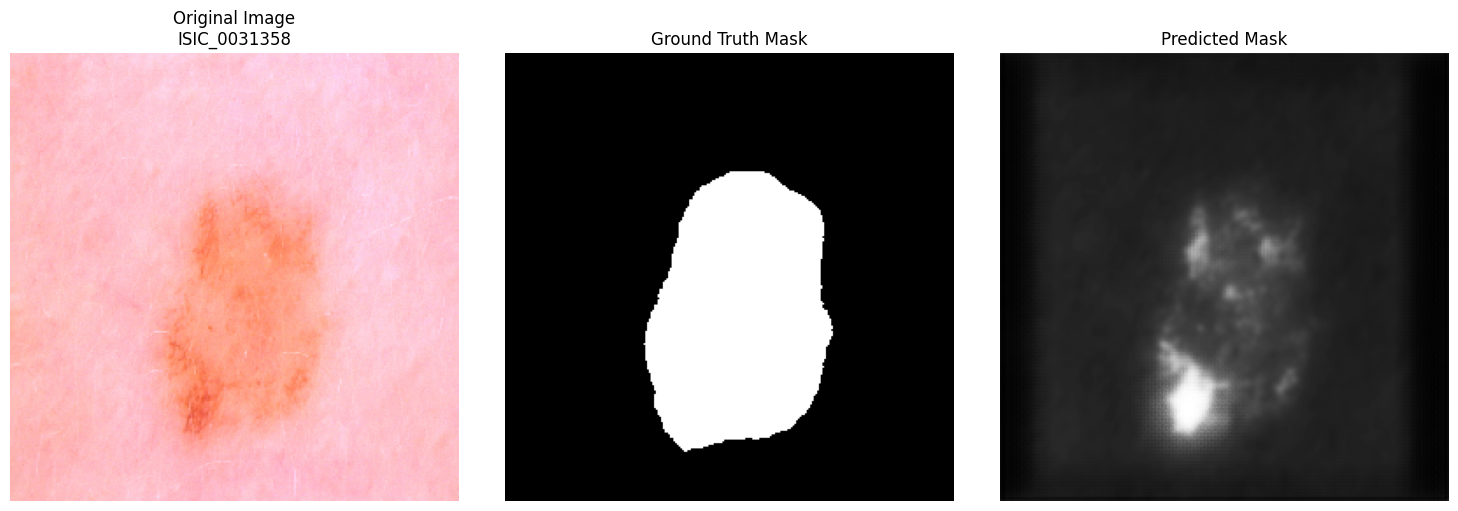

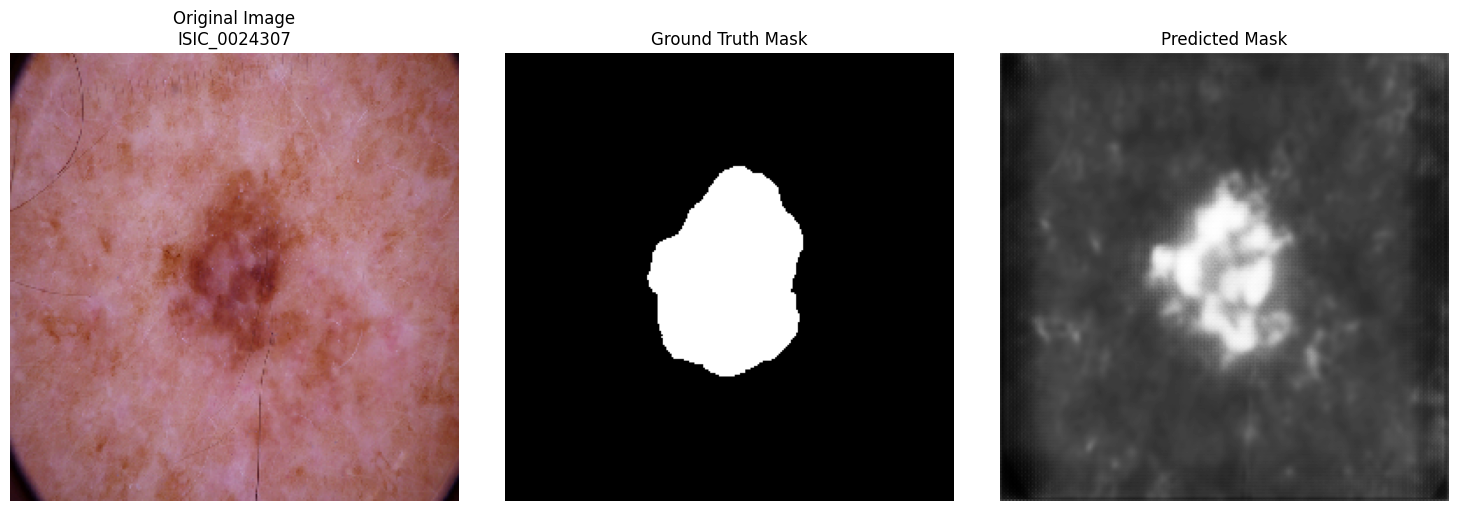

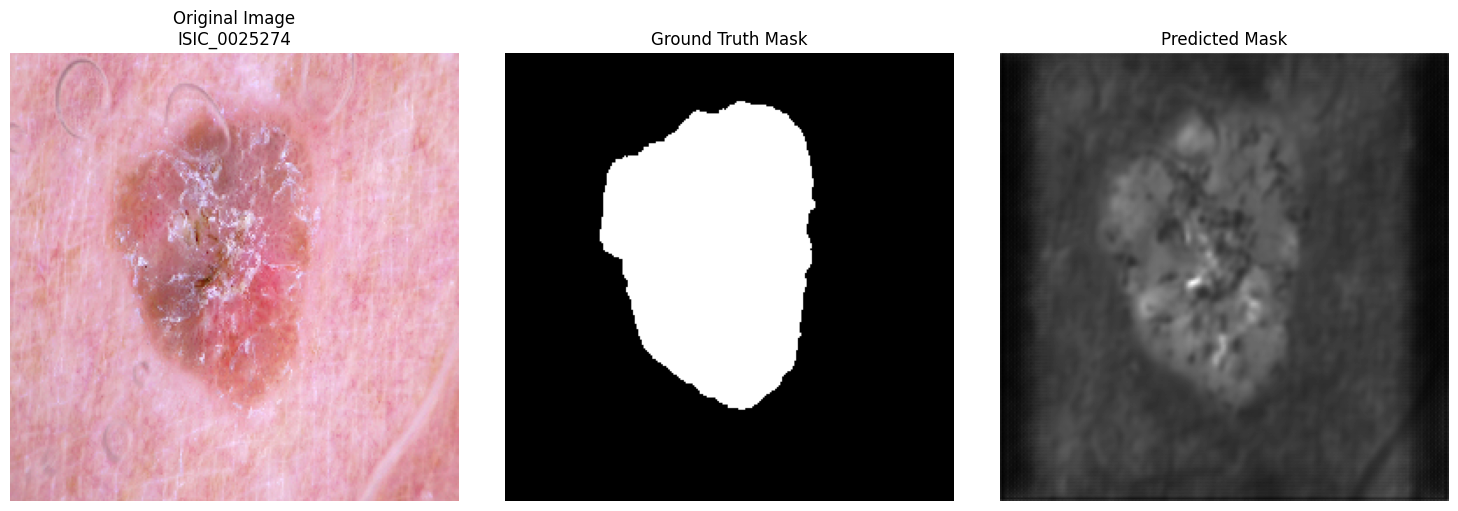

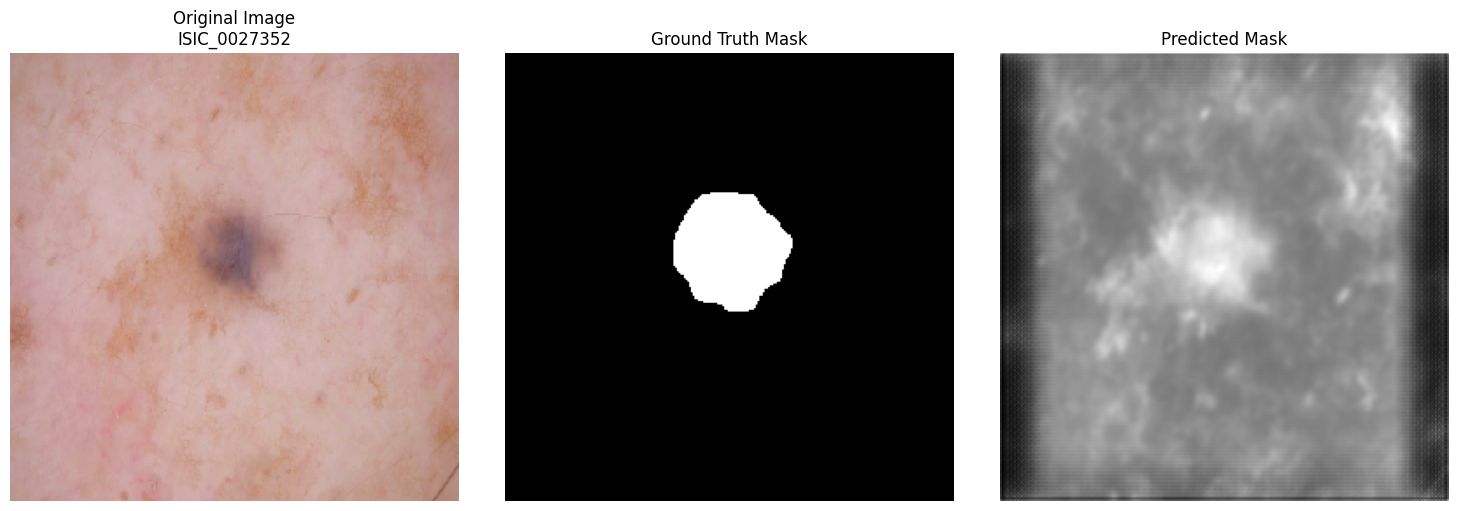

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, Concatenate
import random
from sklearn.metrics import jaccard_score, f1_score, precision_score, recall_score

def create_unet_plus_plus(input_shape=(256, 256, 3)):
    inputs = Input(input_shape)
    conv1_1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1_1 = Conv2D(64, 3, activation='relu', padding='same')(conv1_1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1_1)
    conv2_1 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2_1 = Conv2D(128, 3, activation='relu', padding='same')(conv2_1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2_1)
    conv3_1 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3_1 = Conv2D(256, 3, activation='relu', padding='same')(conv3_1)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3_1)
    conv4_1 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4_1 = Conv2D(512, 3, activation='relu', padding='same')(conv4_1)
    up1_2 = Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv4_1)
    concat1_2 = Concatenate()([up1_2, conv3_1])
    conv1_2 = Conv2D(256, 3, activation='relu', padding='same')(concat1_2)
    up2_2 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv1_2)
    concat2_2 = Concatenate()([up2_2, conv2_1])
    conv2_2 = Conv2D(128, 3, activation='relu', padding='same')(concat2_2)
    up3_2 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv2_2)
    concat3_2 = Concatenate()([up3_2, conv1_1])
    conv3_2 = Conv2D(64, 3, activation='relu', padding='same')(concat3_2)
    outputs = Conv2D(1, 1, activation='sigmoid')(conv3_2)
    return Model(inputs=inputs, outputs=outputs)

def load_and_preprocess_data(ham_image_dir, segmentation_dir, metadata_path, num_samples=10):
    metadata = pd.read_csv(metadata_path)
    seg_files = [f for f in os.listdir(segmentation_dir) if f.endswith('_segmentation.png')]
    image_ids = [f.split('_segmentation')[0] for f in seg_files]
    selected_ids = random.sample(image_ids, min(num_samples, len(image_ids)))
    original_images, ground_truth_masks = [], []
    for img_id in selected_ids:
        original_path = os.path.join(ham_image_dir, f'{img_id}.jpg')
        if not os.path.exists(original_path):
            print(f"Warning: {original_path} not found. Skipping.")
            continue
        original_img = load_img(original_path, target_size=(256, 256))
        original_images.append(img_to_array(original_img) / 255.0)
        seg_img = load_img(os.path.join(segmentation_dir, f'{img_id}_segmentation.png'), target_size=(256, 256), color_mode='grayscale')
        ground_truth_masks.append(img_to_array(seg_img) / 255.0)
    return np.array(original_images), np.array(ground_truth_masks), selected_ids

def evaluate_segmentation(predicted_masks, ground_truth_masks):
    pred_flat, truth_flat = predicted_masks.reshape(-1) > 0.5, ground_truth_masks.reshape(-1) > 0.5
    return {'IoU': jaccard_score(truth_flat, pred_flat), 'F1-Score': f1_score(truth_flat, pred_flat), 'Precision': precision_score(truth_flat, pred_flat), 'Recall': recall_score(truth_flat, pred_flat)}

def visualize_results(original_images, ground_truth_masks, predicted_masks, image_ids, num_samples=5):
    for idx in range(min(num_samples, len(original_images))):
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(original_images[idx])
        plt.title(f'Original Image\n{image_ids[idx]}')
        plt.axis('off')
        plt.subplot(1, 3, 2)
        plt.imshow(ground_truth_masks[idx].squeeze(), cmap='gray')
        plt.title('Ground Truth Mask')
        plt.axis('off')
        plt.subplot(1, 3, 3)
        plt.imshow(predicted_masks[idx].squeeze(), cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')
        plt.tight_layout()
        plt.show()

def main():
    ham_image_dir = r"C:\\Users\\rdeva\\Downloads\\SEM3\\SEM4\\Deep_Learning\\HAM10000_images_part_1"
    segmentation_dir = r"C:\\Users\\rdeva\\Downloads\\SEM3\\SEM4\\Deep_Learning\\archive\\HAM10000_segmentations_lesion_tschandl"
    metadata_path = r"C:\\Users\\rdeva\\Downloads\\SEM3\\SEM4\\Deep_Learning\\HAM10000_metadata.csv"
    print("Loading and preprocessing data...")
    original_images, ground_truth_masks, selected_ids = load_and_preprocess_data(ham_image_dir, segmentation_dir, metadata_path)
    print("Creating and compiling UNet++ model...")
    model = create_unet_plus_plus()
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    X_train, X_val, y_train, y_val = train_test_split(original_images, ground_truth_masks, test_size=0.2, random_state=42)
    print("Training model...")
    model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=8, epochs=50, verbose=1)
    print("Generating predictions...")
    predicted_masks = model.predict(original_images)
    print("Evaluating model...")
    for key, value in evaluate_segmentation(predicted_masks, ground_truth_masks).items():
        print(f"{key}: {value:.4f}")
    print("Visualizing results...")
    visualize_results(original_images, ground_truth_masks, predicted_masks, selected_ids)

if __name__ == "__main__":
    main()


Loading data...
Creating model...
Training...
Epoch 1/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 44s 6s/step - accuracy: 0.6502 - loss: 0.6121 - val_accuracy: 0.1804 - val_loss: 49.1345
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 34s 7s/step - accuracy: 0.8831 - loss: 0.3542 - val_accuracy: 0.1804 - val_loss: 169.9174
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 34s 7s/step - accuracy: 0.8793 - loss: 0.3148 - val_accuracy: 0.1818 - val_loss: 27.7287
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 30s 6s/step - accuracy: 0.8716 - loss: 0.3142 - val_accuracy: 0.1804 - val_loss: 151.1411
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 30s 6s/step - accuracy: 0.8861 - loss: 0.2687 - val_accuracy: 0.1804 - val_loss: 54.3745
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 35s 7s/step - accuracy: 0.9062 - loss: 0.2330 - val_accuracy: 0.2130 - val_loss: 12.8143
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 38s 7s/step - accuracy: 0.9262 - loss: 0.1919 - val_accuracy: 0.2892 - val_loss: 6.2728
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 32s 6s/step - accuracy: 0.9174 - loss: 0.2

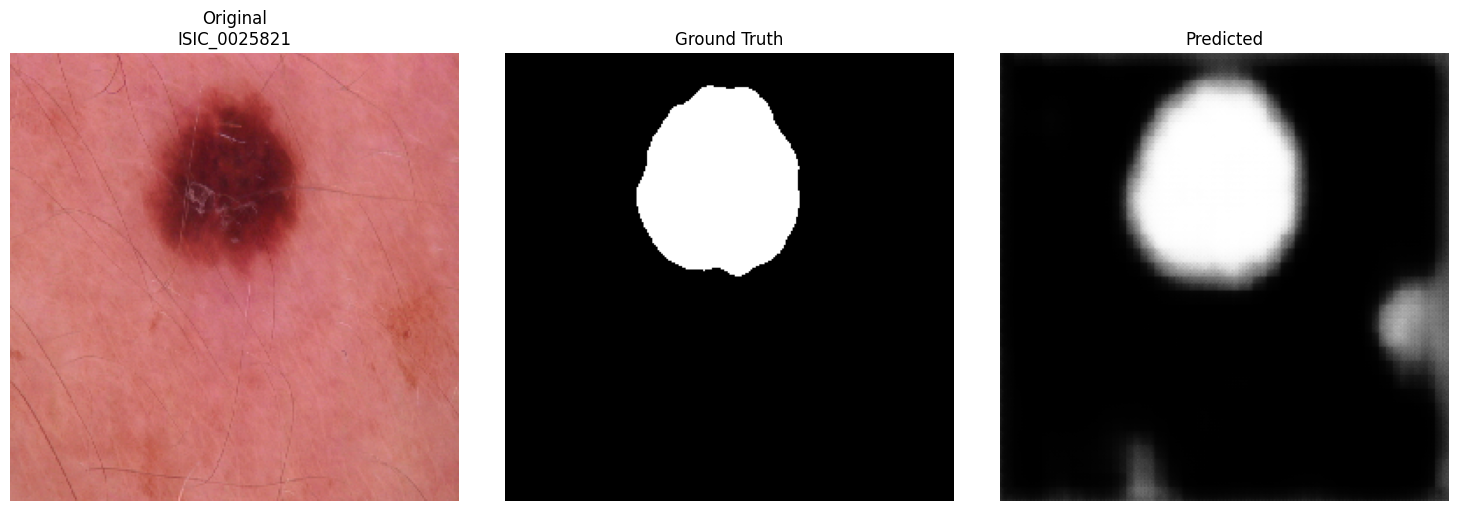

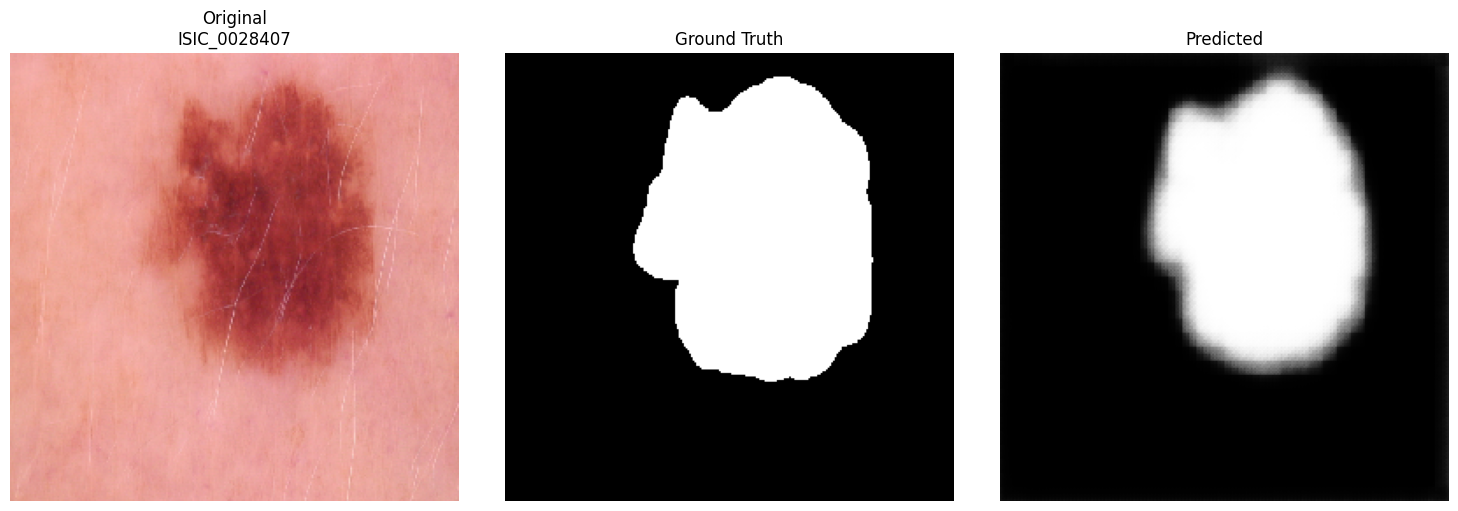

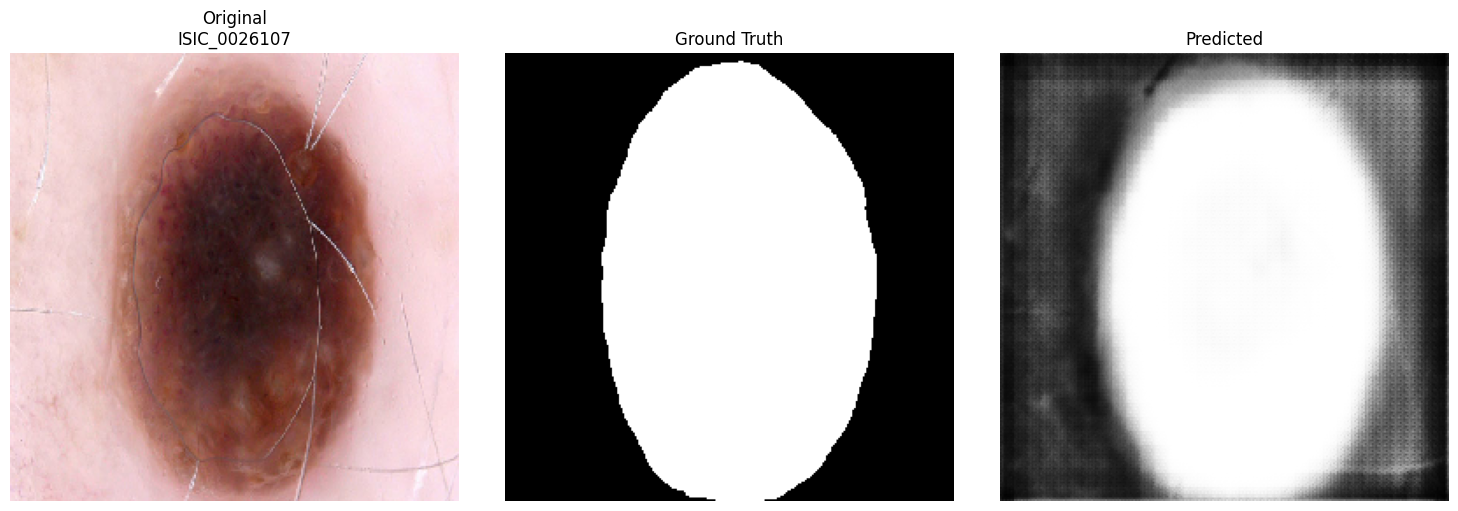

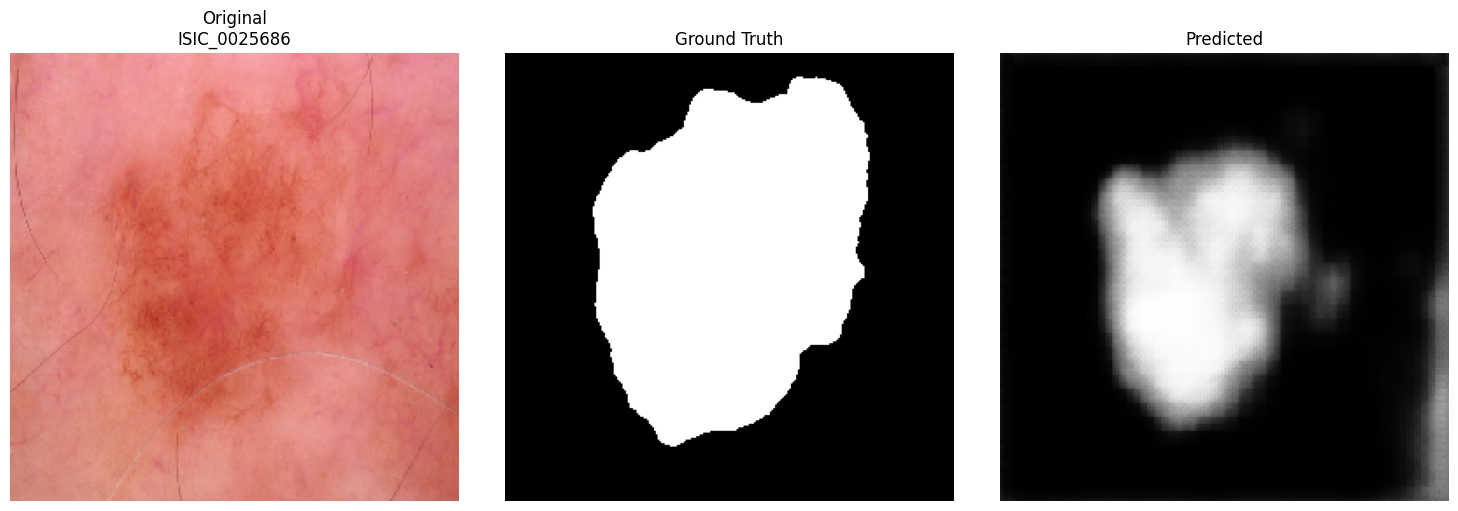

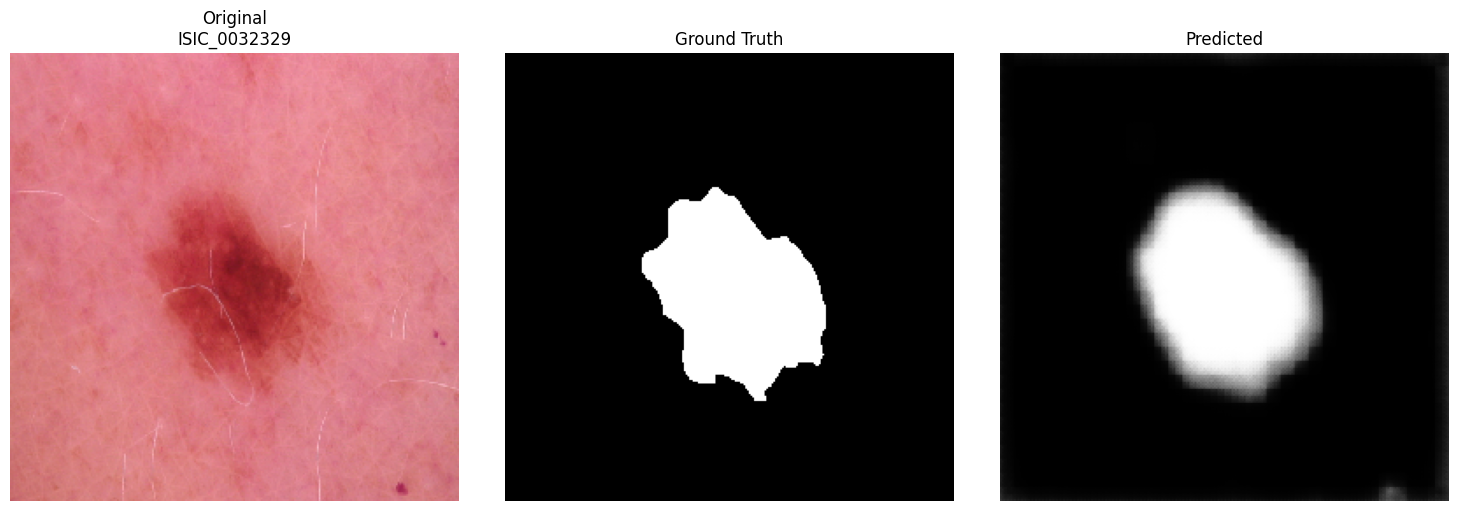

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Conv2D,Conv2DTranspose,MaxPooling2D,Concatenate,BatchNormalization,Activation,Add,GlobalAveragePooling2D,Reshape,Dense,Multiply
from sklearn.metrics import jaccard_score,f1_score,precision_score,recall_score
def squeeze_excite_block(inputs,ratio=8):
    init=inputs
    filters=init.shape[-1]
    se_shape=(1,1,filters)
    se=GlobalAveragePooling2D()(init)
    se=Reshape(se_shape)(se)
    se=Dense(filters//ratio,activation='relu',kernel_initializer='he_normal',use_bias=False)(se)
    se=Dense(filters,activation='sigmoid',kernel_initializer='he_normal',use_bias=False)(se)
    return Multiply()([init,se])
def residual_block(inputs,filters,kernel_size=3):
    x=Conv2D(filters,kernel_size,padding='same',kernel_initializer='he_normal')(inputs)
    x=BatchNormalization()(x)
    x=Activation('relu')(x)
    x=Conv2D(filters,kernel_size,padding='same',kernel_initializer='he_normal')(x)
    x=BatchNormalization()(x)
    x=squeeze_excite_block(x)
    shortcut=Conv2D(filters,kernel_size=1,padding='same',kernel_initializer='he_normal')(inputs)
    shortcut=BatchNormalization()(shortcut)
    x=Add()([x,shortcut])
    x=Activation('relu')(x)
    return x
def attention_gate(inputs,g,inter_channel):
    theta_x=Conv2D(inter_channel,kernel_size=1,padding='same',kernel_initializer='he_normal')(inputs)
    phi_g=Conv2D(inter_channel,kernel_size=1,padding='same',kernel_initializer='he_normal')(g)
    add=Add()([theta_x,phi_g])
    act=Activation('relu')(add)
    psi=Conv2D(1,kernel_size=1,padding='same',kernel_initializer='he_normal')(act)
    sig=Activation('sigmoid')(psi)
    return Multiply()([inputs,sig])
def create_resunet_plusplus(input_shape=(256,256,3)):
    inputs=Input(input_shape)
    x=Conv2D(64,3,padding='same',kernel_initializer='he_normal')(inputs)
    x=BatchNormalization()(x)
    x=Activation('relu')(x)
    x=Conv2D(64,3,padding='same',kernel_initializer='he_normal')(x)
    x=BatchNormalization()(x)
    x=Activation('relu')(x)
    skip1=x
    x=MaxPooling2D()(x)
    x=residual_block(x,128)
    skip2=x
    x=MaxPooling2D()(x)
    x=residual_block(x,256)
    skip3=x
    x=MaxPooling2D()(x)
    x=residual_block(x,512)
    x=Conv2DTranspose(256,2,strides=2,padding='same',kernel_initializer='he_normal')(x)
    att3=attention_gate(skip3,x,256)
    x=Concatenate()([x,att3])
    x=residual_block(x,256)
    x=Conv2DTranspose(128,2,strides=2,padding='same',kernel_initializer='he_normal')(x)
    att2=attention_gate(skip2,x,128)
    x=Concatenate()([x,att2])
    x=residual_block(x,128)
    x=Conv2DTranspose(64,2,strides=2,padding='same',kernel_initializer='he_normal')(x)
    att1=attention_gate(skip1,x,64)
    x=Concatenate()([x,att1])
    x=residual_block(x,64)
    outputs=Conv2D(1,1,activation='sigmoid')(x)
    model=Model(inputs=inputs,outputs=outputs)
    return model
def load_and_preprocess_data(ham_image_dir,segmentation_dir,metadata_path,num_samples=10):
    metadata=pd.read_csv(metadata_path)
    seg_files=[f for f in os.listdir(segmentation_dir)if f.endswith('_segmentation.png')]
    image_ids=[f.split('_segmentation')[0]for f in seg_files]
    selected_ids=random.sample(image_ids,min(num_samples,len(image_ids)))
    original_images=[]
    ground_truth_masks=[]
    for img_id in selected_ids:
        original_path=os.path.join(ham_image_dir,f'{img_id}.jpg')
        if not os.path.exists(original_path):
            print(f"Warning: Original image {original_path} not found. Skipping.")
            continue
        original_img=load_img(original_path,target_size=(256,256))
        original_array=img_to_array(original_img)/255.0
        original_images.append(original_array)
        seg_path=os.path.join(segmentation_dir,f'{img_id}_segmentation.png')
        seg_img=load_img(seg_path,target_size=(256,256),color_mode='grayscale')
        seg_array=img_to_array(seg_img)/255.0
        ground_truth_masks.append(seg_array)
    return np.array(original_images),np.array(ground_truth_masks),selected_ids
def evaluate_segmentation(predicted_masks,ground_truth_masks):
    pred_flat=predicted_masks.reshape(-1)>0.5
    truth_flat=ground_truth_masks.reshape(-1)>0.5
    return{'IoU':jaccard_score(truth_flat,pred_flat),'F1-Score':f1_score(truth_flat,pred_flat),'Precision':precision_score(truth_flat,pred_flat),'Recall':recall_score(truth_flat,pred_flat)}
def visualize_results(original_images,ground_truth_masks,predicted_masks,image_ids,num_samples=5):
    for idx in range(min(num_samples,len(original_images))):
        plt.figure(figsize=(15,5))
        plt.subplot(1,3,1)
        plt.imshow(original_images[idx])
        plt.title(f'Original\n{image_ids[idx]}')
        plt.axis('off')
        plt.subplot(1,3,2)
        plt.imshow(ground_truth_masks[idx].squeeze(),cmap='gray')
        plt.title('Ground Truth')
        plt.axis('off')
        plt.subplot(1,3,3)
        plt.imshow(predicted_masks[idx].squeeze(),cmap='gray')
        plt.title('Predicted')
        plt.axis('off')
        plt.tight_layout()
        plt.show()
def main():
    ham_image_dir=r"C:\\Users\\rdeva\\Downloads\\SEM3\\SEM4\\Deep_Learning\\HAM10000_images_part_1"
    segmentation_dir=r"C:\\Users\\rdeva\\Downloads\\SEM3\\SEM4\\Deep_Learning\\archive\\HAM10000_segmentations_lesion_tschandl"
    metadata_path=r"C:\\Users\\rdeva\\Downloads\\SEM3\\SEM4\\Deep_Learning\\HAM10000_metadata.csv"
    print("Loading data...")
    original_images,ground_truth_masks,selected_ids=load_and_preprocess_data(ham_image_dir,segmentation_dir,metadata_path,num_samples=100)
    print("Creating model...")
    model=create_resunet_plusplus()
    model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
    X_train,X_val,y_train,y_val=train_test_split(original_images,ground_truth_masks,test_size=0.2,random_state=42)
    print("Training...")
    history=model.fit(X_train,y_train,validation_data=(X_val,y_val),batch_size=8,epochs=30,verbose=1)
    print("Predicting...")
    predicted_masks=model.predict(original_images)
    print("Evaluating...")
    metrics=evaluate_segmentation(predicted_masks,ground_truth_masks)
    for k,v in metrics.items():
        print(f"{k}:{v:.4f}")
    visualize_results(original_images,ground_truth_masks,predicted_masks,selected_ids)
if __name__=="__main__":
    main()


In [2]:
# -- coding: utf-8 --
"""
Created on Wed Jan 17 09:12:11 2024

@author: mithun
"""

# -- coding: utf-8 --
"""
Created on Thu Jan 11 16:42:20 2024

@author: mithun
"""

#!/usr/bin/env python3
# -- coding: utf-8 --
"""
Created on Fri Dec 16 05:23:03 2022

@author: mithun
"""

from torch.utils.data import Dataset
from PIL import Image
import os
import pandas as pd
import matplotlib.pylab as plt
import torchvision.transforms.functional as TF
import numpy as np
import random
from PIL import Image, ImageDraw
import torch
from torch.utils.data import Dataset
from PIL import Image
import os
import pandas as pd
import matplotlib.pylab as plt
import torchvision.transforms.functional as TF
import numpy as np
import random
from PIL import Image, ImageDraw
from torch import optim
import cv2
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from PIL import Image
import os
import pandas as pd
import matplotlib.pylab as plt
import torchvision.transforms.functional as TF
import numpy as np
import random
from PIL import Image, ImageDraw
import torch
from torch.utils.data import Dataset
from PIL import Image
import os
import pandas as pd
import matplotlib.pylab as plt
import torchvision.transforms.functional as TF
import numpy as np
import random
from PIL import Image, ImageDraw
from torch import optim


# from torch.utils.data import Dataset
# from PIL import Image
# import os
# import pandas as pd
# import matplotlib.pylab as plt
# import torchvision.transforms.functional as TF
# import numpy as np
# import random
# from PIL import Image, ImageDraw
# import torch
# from torch.utils.data import Dataset
# from PIL import Image
# import os
# import pandas as pd
# import matplotlib.pylab as plt
# import torchvision.transforms.functional as TF
# import numpy as np
# import random
# from PIL import Image, ImageDraw
# from torch import optim

data_dir = r"C:\Users\rdeva\Downloads\SEM3\SEM4\projects\AMD1"
mask_dir2=r"C:\Users\rdeva\Downloads\SEM3\SEM4\projects\vessel1"
imgsList=[pp for pp in os.listdir(data_dir)]
anntsList2=[pp for pp in os.listdir(mask_dir2)]
print("number of images:", len(imgsList))
print("number of annotations:", len(anntsList2))

from albumentations import (HorizontalFlip,VerticalFlip,Compose,Resize)
h,w=256,256

#transform_train = Compose([ Resize(h,w),HorizontalFlip(p=0.5),VerticalFlip(p=0.5),])
transform_train = Compose([ Resize(h,w)])
transform_val = Resize(h,w)
from torch.utils.data import Dataset
from PIL import Image
from torchvision.transforms.functional import to_tensor
#from torchvision.transforms.functional import to_pil_image
from torchvision import transforms, datasets, models

class fetal_dataset(Dataset):
       def __init__(self, path2data,path2label2,num_class, transform=None):
          imgsList=[pp for pp in os.listdir(path2data)]
          anntsList2=[pp for pp in os.listdir(path2label2)]
          self.path2imgs = [os.path.join(path2data, fn) for fn in imgsList]
          self.path2annts2= [os.path.join(path2label2, fn) for fn in anntsList2]
          self.transform = transform
          self.num_class =num_class
       def __len__(self):
          return len(self.path2imgs)
 
       def __getitem__(self, idx):
          path2img = self.path2imgs[idx]
          image = Image.open(path2img)
          path2annt2 = self.path2annts2[idx]
          mask2 = Image.open(path2annt2)
          image= np.array(image)
          mask2=np.asarray(mask2)
          if self.transform: 
             augmented = self.transform(image=image, mask=mask2 )
             image = augmented['image']
             mask2 = augmented['mask']
#             mask2=mask2.transpose(2,1,0)
             mask2=mask2.astype(np.float32)
          image= to_tensor(image)   
          mask2=to_tensor(mask2)
          mask2=mask2/torch.max(mask2)
          
          return image, mask2
  

fetal_ds1=fetal_dataset(data_dir,mask_dir2,1, transform=transform_train)
fetal_ds2=fetal_dataset(data_dir,mask_dir2,1, transform=transform_val)

img,msk1=fetal_ds1[0]
#show_img_mask(img, mask)
print(img.shape, img.type(),torch.max(img))
print(msk1.shape, msk1.type(),torch.max(msk1))
plt.figure(),plt.imshow(img[0])
plt.figure(),plt.imshow(msk1[0])

from sklearn.model_selection import ShuffleSplit
sss = ShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
indices=range(len(fetal_ds1))
for train_index, val_index in sss.split(indices):
    print(len(train_index))
    print("-"*10)
    print(len(val_index))


from torch.utils.data import Subset
train_ds=Subset(fetal_ds1,train_index)
print(len(train_ds))
val_ds=Subset(fetal_ds2,val_index)
print(len(val_ds))

from torch.utils.data import DataLoader
train_dl = DataLoader(train_ds, batch_size=4, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=4, shuffle=False)
for img_b, mask_b in train_dl:
    print(img_b.shape,img_b.dtype)
    print(mask_b.shape, mask_b.dtype)
    break
for img_b, mask_b in val_dl:
    print(img_b.shape,img_b.dtype)
    print(mask_b.shape, mask_b.dtype)
    break
#image_datasets = {'train': train_set, 'val': val_set}
batch_size = 1
dataloaders = {
    'train': DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0),
    'val': DataLoader(val_ds, batch_size=batch_size, shuffle=True, num_workers=0)
}

import torchvision.utils
inputs, masks = next(iter(dataloaders['train']))

print(inputs.shape, masks.shape)


class ConvBlock(nn.Module):
    def __init__(self, ch_in, ch_out):
        super().__init__()
        self.conv = nn.Sequential(
                                  nn.Conv2d(ch_in, ch_out,
                                            kernel_size=3, stride=1,
                                            padding=1, bias=True),
                                  nn.BatchNorm2d(ch_out),
                                  nn.ReLU(inplace=True),
                                  # nn.Conv2d(ch_out, ch_out,
                                  #           kernel_size=3, stride=1,
                                  #           padding=1, bias=True),
                                  # nn.BatchNorm2d(ch_out),
                                  # nn.ReLU(inplace=True),
        )
        
    def forward(self, x):
        x = self.conv(x)
        return x

class UpConvBlock(nn.Module):
    def __init__(self, ch_in, ch_out):
        super().__init__()
        self.up = nn.Sequential(
                                nn.Upsample(scale_factor=2),
                                nn.Conv2d(ch_in, ch_out,
                                         kernel_size=3,stride=1,
                                         padding=1, bias=True),
                                nn.BatchNorm2d(ch_out),
                                nn.ReLU(inplace=True),
        )
        
    def forward(self, x):
        x = x = self.up(x)
        return x



class UNet(nn.Module):
    def __init__(self, n_classes=1, in_channel=1, out_channel=1):
        super().__init__() 
        
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv1 = ConvBlock(ch_in=in_channel, ch_out=64)
        self.conv2 = ConvBlock(ch_in=64, ch_out=128)
        self.conv3 = ConvBlock(ch_in=128, ch_out=256)
        self.conv4 = ConvBlock(ch_in=256, ch_out=512)
        self.conv5 = ConvBlock(ch_in=512, ch_out=1024)
        
        self.up5 = UpConvBlock(ch_in=1024, ch_out=512)
        self.upconv5 = ConvBlock(ch_in=1024, ch_out=512)
        
        self.up4 = UpConvBlock(ch_in=512, ch_out=256)
        self.upconv4 = ConvBlock(ch_in=512, ch_out=256)
        
        self.up3 = UpConvBlock(ch_in=256, ch_out=128)
        self.upconv3 = ConvBlock(ch_in=256, ch_out=128)
        
        self.up2 = UpConvBlock(ch_in=128, ch_out=64)
        self.upconv2 = ConvBlock(ch_in=128, ch_out=64)
        
        self.conv_1x1 = nn.Conv2d(64, out_channel,
                                  kernel_size=1, stride=1, padding=0)
        
    def forward(self, x):
        # encoder
        x1 = self.conv1(x)
        
        x2 = self.maxpool(x1)
        x2 = self.conv2(x2)
        
        x3 = self.maxpool(x2)
        x3 = self.conv3(x3)
        
        x4 = self.maxpool(x3)
        x4 = self.conv4(x4)
        
        x5 = self.maxpool(x4)
        x5 = self.conv5(x5)
        
        # decoder + concat
        d5 = self.up5(x5)
        #
        d5 = torch.concat((x4, d5), dim=1)
        d5 = self.upconv5(d5)
        
        d4 = self.up4(d5)
        d4 = torch.concat((x3, d4), dim=1)
        d4 = self.upconv4(d4)
        
        d3 = self.up3(d4)
        d3 = torch.concat((x2, d3), dim=1)
        d3 = self.upconv3(d3)
        
        d2 = self.up2(d3)
        d2 = torch.concat((x1, d2), dim=1)
        d2 = self.upconv2(d2)
        
        d1 = self.conv_1x1(d2)
        
        return d1

# model = AttentionUNet()
# print(model)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


model = UNet(n_classes=1).to(device)
model=model.to(device)
print(model)
output = torch.randn(1,1,256,256).to(device)
output.shape
torch.Size([1, 1, 256, 256])

from torchsummary import summary
summary(model, input_size=(1, 256, 256),device=device.type)


def dice_loss(pred, target, smooth = 1e-5):
    intersection = (pred * target).sum(dim=(2,3))
    union= pred.sum(dim=(2,3)) + target.sum(dim=(2,3))
    dice= 2.0 * (intersection + smooth) / (union+ smooth)
    loss = 1.0 - dice
    return loss.sum(), dice.sum()

import torch.nn.functional as F
def loss_func(pred, target):
    bce = F.binary_cross_entropy_with_logits(pred, target,reduction='sum')
    pred= torch.sigmoid(pred)
    dlv, _ = dice_loss(pred, target)
    loss = bce + dlv
    return loss
def metrics_batch(pred, target):
    pred= torch.sigmoid(pred)
    _, metric=dice_loss(pred, target)
    return metric

def loss_batch(loss_func, output, target, opt=None):
    loss = loss_func(output, target)
    _, metric_b=dice_loss(output, target)
    if opt is not None:
       opt.zero_grad()
       loss.backward()
       opt.step()
    return loss.item(), metric_b
from torch import optim
opt = optim.Adam(model.parameters(), lr=3e-4)
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']
current_lr=get_lr(opt)
from torch.optim.lr_scheduler import ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=20,verbose=1)

def loss_epoch(model,loss_func,dataset_dl,sanity_check=False,opt=None):
    running_loss=0.0
    running_metric=0.0
    len_data=len(dataset_dl.dataset)
    for xb, yb in dataset_dl:
        xb=xb.type(torch.float32).to(device)
        yb=yb.type(torch.float32).to(device)
        output=model(xb)
        loss_b, metric_b=loss_batch(loss_func, output, yb, opt)
        running_loss += loss_b
        if metric_b is not None:
           running_metric+=metric_b
        if sanity_check is True:
           break
    loss=running_loss/float(len_data)
    metric=running_metric/float(len_data)
    return loss, metric
import time
import copy
def train_val(model, params):
    num_epochs=params["num_epochs"]
    loss_func=params["loss_func"]
    opt=params["optimizer"]
    train_dl=params["train_dl"]
    val_dl=params["val_dl"]
    sanity_check=params["sanity_check"]
    lr_scheduler=params["lr_scheduler"]
    path2weights=params["path2weights"]
    loss_history={"train": [],"val": []}
    metric_history={"train": [],"val": []}
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss=float('inf')
    for epoch in range(num_epochs):
        current_lr=get_lr(opt)
        print('Epoch {}/{}, current lr={}'.format(epoch, num_epochs- 1, current_lr))
        since = time.time()
        model.train() 
        train_loss,train_metric=loss_epoch(model,loss_func,train_dl,sanity_check,opt)
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric.item())
        model.eval()
        with torch.no_grad():
             val_loss,val_metric=loss_epoch(model,loss_func,val_dl,sanity_check)
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric.item())
        if val_loss < best_loss:
           best_loss = val_loss
           best_model_wts = copy.deepcopy(model.state_dict())
           torch.save(model.state_dict(), path2weights)
           print("Copied best model weights!")
        lr_scheduler.step(val_loss)
        #if current_lr == get_lr(opt):
        print("Loading best model weights!")
        model.load_state_dict(best_model_wts)
        print("train loss: %.6f, dice: %.2f"%(train_loss,100*train_metric))
        print("val loss: %.6f, dice: %.2f"%(val_loss,100*val_metric))
        print("-"*10)
        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        model.load_state_dict(best_model_wts)
    return model, loss_history, metric_history

#path2models= "/media/mithun/BA423E4C423E0E1F/1PHD_NITP/2020/Glucoma_Research_Python/New_research/"
# path2models= "E:/Amrita_2024/Attention/"
# if not os.path.exists(path2models):
#    os.mkdir(path2models)
# params_train={
# "num_epochs":2,
# "optimizer": opt,
# "loss_func": loss_func,
# "train_dl": train_dl,
# "val_dl": val_dl,
# "sanity_check": False,
# "lr_scheduler": lr_scheduler,
# "path2weights": path2models+"weights_vessel_attn.pt",
# }
model,loss_hist,metric_hist=train_val(model,params_train)
num_epochs=params_train["num_epochs"]
plt.title("Train-Val Loss")
plt.plot(range(1,num_epochs+1),loss_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),loss_hist["val"],label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()
plt.title("Train-Val Accuracy")
plt.plot(range(1,num_epochs+1),metric_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),metric_hist["val"],label="val")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()    

test_dataset = r"C:\Users\rdeva\Downloads\SEM3\SEM4\projects\new_test_gray"

mask_dir_test_2=r"C:\Users\rdeva\Downloads\SEM3\SEM4\projects\new_test_mask"

test_fetal_ds1=fetal_dataset(test_dataset,mask_dir_test_2,1, transform=transform_val)
test_img,test_msk1=test_fetal_ds1[0]

#show_img_mask(img, mask)
print(test_img.shape, test_img.type(),torch.max(test_img))
print(test_msk1.shape, test_msk1.type(),torch.max(test_msk1))

test_loader = DataLoader(test_fetal_ds1, batch_size=1, shuffle=True)
#inputs, masks = next(iter(test_loader))

#print(inputs.shape, masks.shape)

def reverse_transform(inp):
    inp = inp.numpy().transpose((2, 1, 0))
    #mean = np.array([0.485, 0.456, 0.406])
    #std = np.array([0.229, 0.224, 0.225])
    #inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    inp = (inp * 255).astype(np.uint8)

    return inp

inputs, labels = next(iter(test_loader))
plt.figure()
#plt.imshow(reverse_transform(inputs))
inputs = inputs.to(device)
labels = labels.to(device)
print(inputs.shape, labels.shape)
#
#
## Predict
pred = model(inputs)
## The loss functions include the sigmoid function.
pred = torch.sigmoid(pred)
pred = pred.data.cpu().numpy()
print(pred.shape)
pred=np.squeeze(pred)
print(pred.shape)
print(pred)
plt.figure()
plt.imshow(pred)
plt.figure()
plt.imshow(pred,cmap='gray')

number of images: 1
number of annotations: 1


PermissionError: [Errno 13] Permission denied: 'C:\\Users\\rdeva\\Downloads\\SEM3\\SEM4\\projects\\AMD1\\AMD1'

In [3]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())  # Check if CUDA is detected


2.6.0+cu118
True
